In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the latest date of record
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date of record is {latest}.")

date_start_query = "2016-08-23"
print(f"Therefore, query begins on {date_start_query}.")

date_prcp = pd.read_sql("select date, prcp from measurement where date >= '2016-08-23';", engine)

# Average prcp across stations
date_prcp_avg = date_prcp.groupby(["date"]).mean()
date_prcp_avg.head()

The last date of record is 2017-08-23.
Therefore, query begins on 2016-08-23.


,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


In [11]:
import matplotlib.dates as mdates

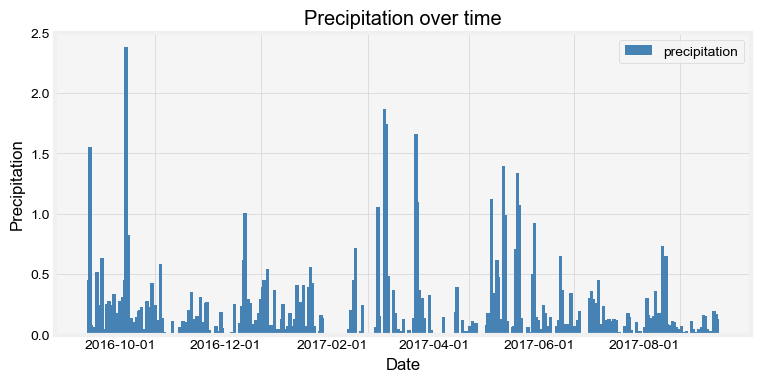

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

plt.rcParams['figure.dpi']= 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

#plot data
plt.figure(figsize=(8,4))
plt.bar(pd.to_datetime(date_prcp_avg.index), date_prcp_avg["prcp"], color="steelblue", 
        width=2, label="precipitation")
plt.gca().set_facecolor("whitesmoke")
plt.xticks(ha="center")

# Format x-tick label
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(ha="right")

# Other formatting
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation over time")
plt.legend(frameon=True, facecolor="whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()[0][0]
print(f"There are {num_stations} stations in total.")

There are 9 stations in total.


In [15]:
import pprint

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)). \
                    group_by(Measurement.station). \
                    order_by(func.count(Measurement.prcp).desc()).all()
pprint.pprint(active_stations)
print(f"\nStation {active_stations[0][0]} has the highest number of observations.")

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

Station USC00519281 has the highest number of observations.


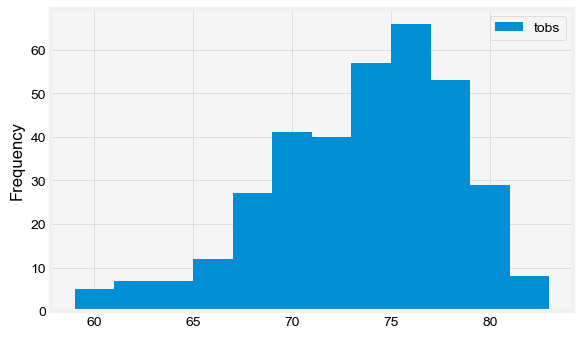

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

tobs_raw = session.query(Measurement.tobs). \
    filter(Measurement.date >= date_start_query). \
    filter(Measurement.station == active_stations[0][0]).all()

tobs = [temp[0] for temp in tobs_raw]

# Plot
plt.hist(tobs, bins=12, label="tobs")
plt.gca().set_facecolor("whitesmoke")
plt.ylabel("Frequency")
plt.legend(frameon=True, facecolor="whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.savefig('results/temp_hist.png', bbox_inches="tight", dpi = 300)

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(Measurement.date>=start_date_dt).filter(Measurement.date<=end_date_dt).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.4375, 74.0)


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = "2017-03-01"
end_date = "2017-03-14"
[temp_min, temp_avg, temp_max] = calc_temps(start_date, end_date)

print(f"My trip starts on {start_date} and ends on {end_date}. \
For the range of dates, the min temperature is {temp_min}, \
mean temperature is {temp_avg}, and maximum temperature is {temp_max}.")

My trip starts on 2017-03-01 and ends on 2017-03-14. For the range of dates, the min temperature is 62.0, mean temperature is 71.21518987341773, and maximum temperature is 82.0.


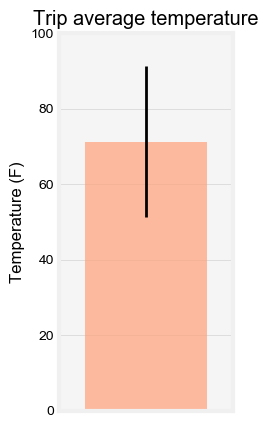

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(0, temp_avg, color="lightsalmon", width=1.4, 
        alpha=0.7, yerr=temp_max-temp_min, error_kw={"linewidth":2})
plt.gca().set_facecolor("whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.gca().set_xticks([])
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.ylabel("Temperature (F)")
plt.title("Trip average temperature")
plt.savefig('Results/temp_avg.png', bbox_inches="tight", dpi = 300)

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

session.query(Measurement.station, func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00513117', 0.2738461538461538),
 ('USC00519281', 0.25230769230769223),
 ('USC00519523', 0.21625),
 ('USC00516128', 0.13636363636363638),
 ('USC00517948', 0.12800000000000003),
 ('USC00519397', 0.11923076923076922),
 ('USC00514830', 0.105)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel). \
                    filter(func.date(Measurement.date).like(f'%{date}%')).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dates = ["02-01", "02-02", "02-03", "02-04", "02-05", "02-06", "02-07"]
normals = [daily_normals(date1) for date1 in dates]

# To dataframe
df_normals = pd.DataFrame(normals, index=dates, columns=["min", "avg", "max"])
df_normals

,min,avg,max
02-01,56.0,68.140351,78.0
02-02,59.0,68.859649,77.0
02-03,58.0,67.796610,77.0
02-04,61.0,68.140351,76.0
02-05,59.0,69.684211,80.0
02-06,58.0,70.389831,77.0
02-07,60.0,69.000000,77.0


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


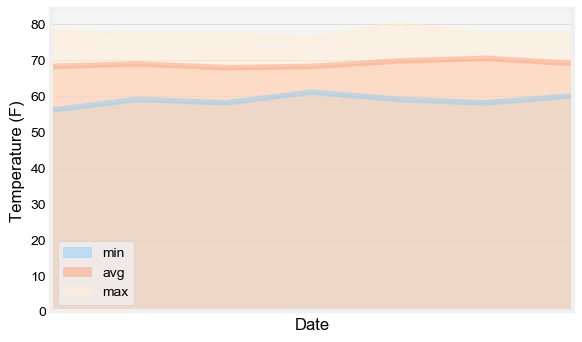

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot.area(stacked=False, color=["lightskyblue", "lightsalmon", "papayawhip"])

ax = plt.gca()
ax.set_facecolor("whitesmoke")

# Format x-tick label
locs = ax.xaxis.get_ticklocs()[1:-1]
plt.xticks(locs, df_normals.index, rotation=45, ha="right")


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(ha="right")

# Other formatting
plt.xlim((locs[0], locs[-1]))
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
ax.set_axisbelow(True)
plt.savefig('results/daily_normals.png', bbox_inches="tight", dpi = 300)